In [1]:
#Import Library
from google.colab import drive
import os
import zipfile


In [2]:
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [3]:
from io import BytesIO
from IPython.display import Image as IMG
from google.colab import files
from keras.preprocessing import image
from shutil import copyfile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlopen

In [4]:
#Import Dataset (dataset dari https://www.kaggle.com/madisona/translated-animals10/)
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
local_zip = '/content/drive/MyDrive/animal.zip' 
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/animals/')
zip_ref.close()

In [6]:
animals = ['dog', 'chicken', 'spider']

for animal in animals:
    print(f'{animal} images: ', len(os.listdir(f'/content/animals/animals10/raw-img/{animal}')))

dog images:  4863
chicken images:  3098
spider images:  4821


In [7]:

try:
  os.mkdir('/content/animals/animals10/raw-img/training')
  os.mkdir('/content/animals/animals10/raw-img/testing')
  for animal in animals:
    os.mkdir(f'/content/animals/animals10/raw-img/training/{animal}')
    os.mkdir(f'/content/animals/animals10/raw-img/testing/{animal}')
except OSError:
  pass

In [8]:
def split_data(images_path, training_path, testing_path, split_size):
    files = []
    for filename in os.listdir(images_path):
        file = images_path + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " others")

    training_length = int(len(files) * split_size)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = images_path + filename
        destination = training_path + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = images_path + filename
        destination = testing_path + filename
        copyfile(this_file, destination)





In [9]:
split_size = 0.8 # pembagian train 80 dan test 20

dog_path = "/content/animals/animals10/raw-img/dog/"
dog_train = "/content/animals/animals10/raw-img/training/dog/"
dog_test = "/content/animals/animals10/raw-img/testing/dog/"
split_data(dog_path, dog_train, dog_test, split_size)

chicken_path = "/content/animals/animals10/raw-img/chicken/"
chicken_train = "/content/animals/animals10/raw-img/training/chicken/"
chicken_test = "/content/animals/animals10/raw-img/testing/chicken/"
split_data(chicken_path, chicken_train, chicken_test, split_size)

spider_path = "/content/animals/animals10/raw-img/spider/"
spider_train = "/content/animals/animals10/raw-img/training/spider/"
spider_test = "/content/animals/animals10/raw-img/testing/spider/"
split_data(spider_path, spider_train, spider_test, split_size)

In [10]:
train = len(os.listdir(dog_train)) + len(os.listdir(chicken_train)) + \
        len(os.listdir(spider_train))
test  = len(os.listdir(dog_test)) + len(os.listdir(chicken_test)) + \
        len(os.listdir(spider_test))

print("Jumlah data train = " + str(train) + " Images")
print("jumlah validasi = " + str(test)+ " Images")

Jumlah data train = 10224 Images
jumlah validasi = 2558 Images


In [11]:
TRAIN_DIR = '/content/animals/animals10/raw-img/training'
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
) 

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150,150)
)

VAL_DIR = "/content/animals/animals10/raw-img/testing"
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size = 64,
    class_mode = 'categorical',
    target_size = (150, 150)
)

Found 10224 images belonging to 3 classes.
Found 2558 images belonging to 3 classes.


In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi telah >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(train_generator, epochs=300, callbacks = [callbacks], verbose=1, validation_data=val_generator)

Epoch 1/300
160/160 [==============================] - 105s 451ms/step - loss: 0.9456 - accuracy: 0.5369 - val_loss: 0.7299 - val_accuracy: 0.6716
Epoch 2/300
160/160 [==============================] - 70s 437ms/step - loss: 0.7452 - accuracy: 0.6725 - val_loss: 0.8021 - val_accuracy: 0.6306
Epoch 3/300
160/160 [==============================] - 69s 434ms/step - loss: 0.6439 - accuracy: 0.7333 - val_loss: 0.6134 - val_accuracy: 0.7244
Epoch 4/300
160/160 [==============================] - 69s 434ms/step - loss: 0.5579 - accuracy: 0.7763 - val_loss: 0.6953 - val_accuracy: 0.6966
Epoch 5/300
160/160 [==============================] - 69s 434ms/step - loss: 0.4951 - accuracy: 0.8044 - val_loss: 0.5305 - val_accuracy: 0.7952
Epoch 6/300
160/160 [==============================] - 70s 437ms/step - loss: 0.4756 - accuracy: 0.8125 - val_loss: 0.4973 - val_accuracy: 0.8038
Epoch 7/300
160/160 [==============================] - 70s 436ms/step - loss: 0.4278 - accuracy: 0.8330 - val_loss: 0.4129 

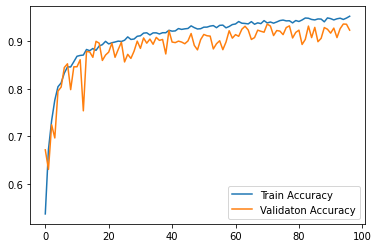

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validaton Accuracy")
plt.legend()
plt.show()

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvcyal7az/assets


Saving OIP-_2Itmpob3Q0nbJKrHvtnfAHaJ3.jpeg to OIP-_2Itmpob3Q0nbJKrHvtnfAHaJ3 (1).jpeg
OIP-_2Itmpob3Q0nbJKrHvtnfAHaJ3.jpeg
Ini Gambar Anjing


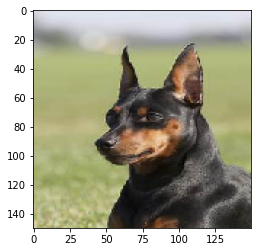

In [26]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('Ini Gambar Ayam')
  elif classes[0,1]!=0:
    print('Ini Gambar Anjing')
  else:
    print('Ini Gambar Laba-Laba')

Saving e832b40a20f61c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg to e832b40a20f61c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640 (1).jpg
e832b40a20f61c22d2524518b7444f92e37fe5d404b0144390f8c47ba6edbc_640.jpg
Ini Gambar Laba-Laba


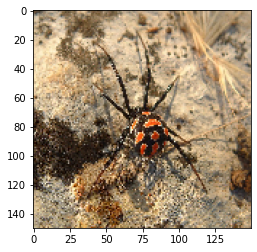

In [27]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('Ini Gambar Ayam')
  elif classes[0,1]!=0:
    print('Ini Gambar Anjing')
  else:
    print('Ini Gambar Laba-Laba')